In [1]:

import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
rng = numpy.random

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0050 cost= 0.097397551 W= 0.17004904 b= 1.3737043
Epoch: 0100 cost= 0.095049046 W= 0.17477982 b= 1.3396711
Epoch: 0150 cost= 0.092971094 W= 0.17922951 b= 1.3076607
Epoch: 0200 cost= 0.091132514 W= 0.18341462 b= 1.2775532
Epoch: 0250 cost= 0.089505844 W= 0.18735082 b= 1.2492366
Epoch: 0300 cost= 0.088066503 W= 0.19105302 b= 1.222603
Epoch: 0350 cost= 0.086793214 W= 0.19453448 b= 1.197558
Epoch: 0400 cost= 0.085666642 W= 0.19780862 b= 1.1740036
Epoch: 0450 cost= 0.084669784 W= 0.20088811 b= 1.1518502
Epoch: 0500 cost= 0.083787680 W= 0.20378458 b= 1.1310132
Optimization Finished!
Training cost= 0.08378768 W= 0.20378458 b= 1.1310132 

Model saved in path: /tmp/tf/model.ckpt


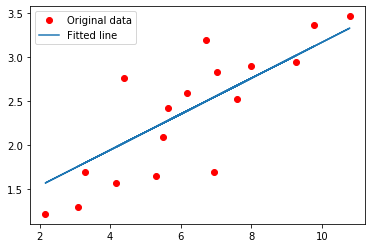

In [2]:
# Parameters
learning_rate = 0.01
training_epochs = 500
display_step = 50
# Training Data
train_X = numpy.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = numpy.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]
# tf Graph Input
# You must name the variables and placeholders, as the names will be later used!!!
X = tf.placeholder("float", name='X')
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")
# Construct a linear model
pred = tf.add(tf.multiply(X, W), b, name='pred')
# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
# Start training
# sess = tf.Session()
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/tf/model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    #Graphic display - matplotlib
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()

In [ ]:
# import the inspect_checkpoint library
from tensorflow.python.tools import inspect_checkpoint as chkp

# print all tensors in checkpoint file
chkp.print_tensors_in_checkpoint_file("/tmp/tf/model.ckpt", tensor_name='', all_tensors=True)

In [9]:
def predict(sess, inputs):
    preds = sess.run('pred:0', feed_dict={'X:0': inputs}) 
    # `X` is used, it must be defined in the model with that name explicitly!
    return [str(p) for p in preds]

In [3]:

from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
clipper_conn.start_clipper()

20-04-08:00:22:10 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-04-08:00:22:14 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmpng0_hl16.yml
20-04-08:00:22:16 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [5]:
clipper_conn.connect()

20-04-08:00:22:18 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [6]:
# List all applications
clipper_conn.get_all_apps()

[]

In [ ]:

# List all models
clipper_conn.get_all_models()

In [7]:

# Add an application with a name and an input type
clipper_conn.register_application(
    name="tf-app", input_type="doubles", default_output="-1.0", slo_micros=100000)

20-04-08:00:22:27 INFO     [clipper_admin.py:236] [default-cluster] Application tf-app was successfully registered


In [10]:

# Deploy a model, to check what arguments you need run 
# "?deploy_tensorflow_model" to let the notebook show you the definition of the method
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod",
    version=1,
    input_type="doubles",
    func=predict,
    tf_sess_or_saved_model_path="/tmp/tf/") # path to saved model files is used,
# session example in the next section

20-04-08:00:22:42 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpfqtdnyqtclipper
20-04-08:00:22:42 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-04-08:00:22:42 INFO     [tensorflow.py:264] TensorFlow model copied to: tfmodel 
20-04-08:00:22:42 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-04-08:00:22:42 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpfqtdnyqtclipper
20-04-08:00:22:43 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-04-08:00:22:43 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-04-08:00:22:43 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpfqtdnyqtclipper /model/
20-04-08:00:22:43 INFO     [clipper_admin.py:539] [default-cluster]  ---> 5d311020dc15
20-04-08:00:22:43 INFO     [clipper_admin.py:539] [default-cluster] Successfully built 5d311020dc15
20-04-08:00:2

In [11]:
# Link the model and the app
clipper_conn.link_model_to_app(
    app_name="tf-app",
    model_name="tf-mod")


20-04-08:00:22:51 INFO     [clipper_admin.py:303] [default-cluster] Model tf-mod is now linked to application tf-app


In [ ]:

# Show the apps again, should list one
clipper_conn.get_all_apps()

In [12]:
# Get query address
query_address = clipper_conn.get_query_addr()

In [15]:

# Run a query
import requests, json, numpy as np
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()

{'query_id': 2, 'output': '[1.2940408 1.7831239]', 'default': False}

In [ ]:
# Clipper allows to deploy a TensorFlow model using a session variable too
# First the model must be restored from the files
# Pay attention to the fact that variables/placeholders are restored 
# with exactly the same names
tf.reset_default_graph()

W = tf.get_variable("weight", shape=[])
b = tf.get_variable("bias", shape=[])

X = tf.placeholder("float", name='X')
pred = tf.add(tf.multiply(X, W), b, name='pred')

saver = tf.train.Saver()
sess = tf.Session()

# Restore variables from disk.
saver.restore(sess, "/tmp/tf/model.ckpt")
print("Model restored.")
print("W : %s" % W.eval(session=sess))
print("b : %s" % b.eval(session=sess))

In [ ]:

# Check that the session variable exists
sess

In [ ]:
deploy_tensorflow_model(
    clipper_conn,
    name="tf-mod",
    version=2, # version 2 of the same model, `predict` endpoint will be updated 
    # automatically to the newest model version
    input_type="doubles",
    func=predict,
    tf_sess_or_saved_model_path=sess) # `sess` variable is used here

In [ ]:

# Session can be closed now
sess.close()

In [ ]:
# Run a query
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()
# The result is the same

In [ ]:
# You can revert to the previous model version, the query endpoint remains the same
clipper_conn.set_model_version("tf-mod", "1")

In [ ]:
# Replicate the model 5 times
clipper_conn.set_num_replicas("tf-mod", 5)

In [ ]:
# Back to one replica
clipper_conn.set_num_replicas("tf-mod", 1)

In [ ]:
# You can also register more applications - connections to the model and link them to it
clipper_conn.register_application(
    name="tf-app-extra", input_type="doubles", default_output="-1.0", slo_micros=100000)
# You have to link them the standard way. You can also link an existing application 
# to another model if you wish using the same method
clipper_conn.link_model_to_app(
    app_name="tf-app-extra",
    model_name="tf-mod")

In [ ]:
# Run a query with an endpoint `tf-app-extra/predict`
headers = {"Content-type": "application/json"}
requests.post("http://"+query_address+"/tf-app-extra/predict", headers=headers, data=json.dumps({
    "input": [.8, 3.2]})).json()

In [ ]:
# Unlink the model and the apps
clipper_conn.unlink_model_from_app(model_name="tf-mod", app_name="tf-app")
clipper_conn.unlink_model_from_app(model_name="tf-mod", app_name="tf-app-extra")

In [ ]:
# Stop the model
clipper_conn.stop_models('tf-mod')

In [ ]:
# Remove the apps
clipper_conn.delete_application('tf-app')
clipper_conn.delete_application('tf-app-extra')

In [16]:
# Stop Clipper
clipper_conn.stop_all()

20-04-08:00:44:53 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers
